In [1]:
import spacy
import gensim
import pandas as pd
import nltk
import numpy as np
import seaborn as sn
import re
import string
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from gensim.models.fasttext import FastText
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from MeanVectorizer import MeanEmbeddingVectorizer
from sklearn.utils import resample

nlp = spacy.blank('id')
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_excel("dataset_twitter.xlsx")
df.head()

,label,komentar
0,positif,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
1,positif,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
2,positif,Sharing sama temen tuh emg guna bgt. Disaat lu...
3,positif,"sangat bersyukur bisa mendoakan kakeknya, Bung..."
4,positif,H-9. Mau ke bank rame bgt ampe antrian tempat ...


In [3]:
komentar = df['komentar'].astype(str)

# Huruf kecil
komentar = komentar.apply(lambda x: x.lower())

# Hapus URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

# Hapus angka
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

# Hapus tanda baca
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Hapus diluar alphabet dan numeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

# Tokenizing data
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

,label,komentar
0,positif,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
1,positif,"[sharing, pengalaman, aja, kemarin, jam, batal..."
2,positif,"[sharing, sama, temen, tuh, emg, guna, bgt, di..."
3,positif,"[sangat, bersyukur, bisa, mendoakan, kakeknya,..."
4,positif,"[h, mau, ke, bank, rame, bgt, ampe, antrian, t..."
...,...,...
3110,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
3111,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
3112,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
3113,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [4]:
df['label'].value_counts()

negatif    1101
positif    1017
netral      997
Name: label, dtype: int64

In [5]:
df = df[df.komentar.astype(bool)]

df_pos = df[df['label'] == 'positif']
X_pos_text = df_pos['komentar']
y_pos_label = df_pos['label']

df_neg = df[df['label'] == 'negatif']
X_neg_text = df_neg['komentar']
y_neg_label = df_neg['label']

df_net = df[df['label'] == 'netral']
X_net_text = df_net['komentar']
y_net_label = df_net['label']

In [6]:
X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(X_pos_text, y_pos_label, test_size=0.2, random_state=1, stratify=y_pos_label)
X_neg_train, X_neg_test, y_neg_train, y_neg_test = train_test_split(X_neg_text, y_neg_label, test_size=0.2, random_state=1, stratify=y_neg_label)
X_net_train, X_net_test, y_net_train, y_net_test = train_test_split(X_net_text, y_net_label, test_size=0.2, random_state=1, stratify=y_net_label)

In [7]:
X_net_train_up = resample(X_net_train, replace=True, n_samples=int(len(X_pos_train)))
y_net_train_up = resample(y_net_train, replace=True, n_samples=int(len(y_pos_train)))

X_neg_train_up = resample(X_neg_train, replace=True, n_samples=int(len(X_pos_train)))
y_neg_train_up = resample(y_neg_train, replace=True, n_samples=int(len(y_pos_train)))

In [8]:
X_train = pd.concat([X_pos_train, X_neg_train_up])
X_train = pd.concat([X_train, X_net_train_up])
y_train = pd.concat([y_pos_train, y_neg_train_up])
y_train = pd.concat([y_train, y_net_train_up])

X_test = pd.concat([X_pos_test, X_neg_test])
X_test = pd.concat([X_test, X_net_test])
y_test = pd.concat([y_pos_test, y_neg_test])
y_test = pd.concat([y_test, y_net_test])

In [9]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [10]:
print(y_train.value_counts())

netral     813
positif    813
negatif    813
Name: label, dtype: int64


In [11]:
model = FastText.load('Model/XGB.bin')

In [12]:
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [13]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [14]:
lc = preprocessing.LabelEncoder()
lc.fit(y_train)

LabelEncoder()

In [15]:
y_train_enc=lc.transform(y_train)
y_test_enc=lc.transform(y_test)

In [16]:
train=xgb.DMatrix(X_train_vector,label=y_train_enc)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

In [17]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.5
# Max Depth:  12
# Subsample:  0.4
# Colsample Bytree:  0.3
# Alpha:  0.01
# Lamda:  2
# Min Child Weight:  3
# Number of Trees:  1000

# param['num_class']=len(set(y_train))
# param['objective'] = 'multi:softmax'
# param['learning_rate'] = 0.01
# param['gamma'] = 0.1
# param['max_depth'] = 10
# param['subsample'] = 0.7
# param['colsample_bytree'] = 1
# param['reg_alpha'] = 1
# param['reg_lambda'] = 1
# param['min_child_weight'] = 5
# num_round = 1000

param['num_class']=len(set(y_train))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.5
param['max_depth'] = 12
param['subsample'] = 0.4
param['colsample_bytree'] = 0.3
param['reg_alpha'] = 0.01
param['reg_lambda'] = 2
param['min_child_weight'] = 3
num_round = 1000

watchlist = [(train, 'train'), (test, 'test')]
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.33251	test-merror:0.59680
[1]	train-merror:0.23288	test-merror:0.54240
[2]	train-merror:0.18368	test-merror:0.52320
[3]	train-merror:0.16031	test-merror:0.50880
[4]	train-merror:0.14514	test-merror:0.49920
[5]	train-merror:0.11931	test-merror:0.46240
[6]	train-merror:0.10168	test-merror:0.47360
[7]	train-merror:0.09594	test-merror:0.49120
[8]	train-merror:0.08651	test-merror:0.48640
[9]	train-merror:0.07216	test-merror:0.48160
[10]	train-merror:0.07380	test-merror:0.47520
[11]	train-merror:0.06560	test-merror:0.47040
[12]	train-merror:0.05863	test-merror:0.45440
[13]	train-merror:0.05371	test-merror:0.46240
[14]	train-merror:0.04879	test-merror:0.47520
[15]	train-merror:0.04879	test-merror:0.47040
[16]	train-merror:0.04510	test-merror:0.46880
[17]	train-merror:0.04223	test-merror:0.47840
[18]	train-merror:0.04059	test-merror:0.48000
[19]	train-merror:0.03895	test-merror:0.47840
[20]	train-merror:0.03444	test-merror:0.47200
[21]	train-merror:0.03157	test-merror:0.4672

[177]	train-merror:0.00328	test-merror:0.44160
[178]	train-merror:0.00287	test-merror:0.44640
[179]	train-merror:0.00287	test-merror:0.44480
[180]	train-merror:0.00369	test-merror:0.44480
[181]	train-merror:0.00328	test-merror:0.44960
[182]	train-merror:0.00287	test-merror:0.44480
[183]	train-merror:0.00246	test-merror:0.44960
[184]	train-merror:0.00287	test-merror:0.45600
[185]	train-merror:0.00328	test-merror:0.45440
[186]	train-merror:0.00287	test-merror:0.45440
[187]	train-merror:0.00287	test-merror:0.45280
[188]	train-merror:0.00328	test-merror:0.45600
[189]	train-merror:0.00287	test-merror:0.45280
[190]	train-merror:0.00287	test-merror:0.45600
[191]	train-merror:0.00287	test-merror:0.45280
[192]	train-merror:0.00246	test-merror:0.45120
[193]	train-merror:0.00246	test-merror:0.44640
[194]	train-merror:0.00205	test-merror:0.45120
[195]	train-merror:0.00205	test-merror:0.45280
[196]	train-merror:0.00205	test-merror:0.45280
[197]	train-merror:0.00205	test-merror:0.44960
[198]	train-m

[352]	train-merror:0.00041	test-merror:0.44160
[353]	train-merror:0.00041	test-merror:0.44160
[354]	train-merror:0.00041	test-merror:0.44480
[355]	train-merror:0.00041	test-merror:0.44160
[356]	train-merror:0.00041	test-merror:0.44320
[357]	train-merror:0.00041	test-merror:0.44640
[358]	train-merror:0.00041	test-merror:0.44480
[359]	train-merror:0.00041	test-merror:0.44640
[360]	train-merror:0.00041	test-merror:0.44640
[361]	train-merror:0.00000	test-merror:0.44800
[362]	train-merror:0.00000	test-merror:0.44640
[363]	train-merror:0.00000	test-merror:0.44000
[364]	train-merror:0.00000	test-merror:0.44320
[365]	train-merror:0.00000	test-merror:0.44480
[366]	train-merror:0.00000	test-merror:0.44480
[367]	train-merror:0.00000	test-merror:0.44320
[368]	train-merror:0.00000	test-merror:0.44320
[369]	train-merror:0.00000	test-merror:0.44480
[370]	train-merror:0.00000	test-merror:0.44480
[371]	train-merror:0.00000	test-merror:0.44320
[372]	train-merror:0.00000	test-merror:0.44320
[373]	train-m

[527]	train-merror:0.00000	test-merror:0.43520
[528]	train-merror:0.00000	test-merror:0.43680
[529]	train-merror:0.00000	test-merror:0.43680
[530]	train-merror:0.00000	test-merror:0.43680
[531]	train-merror:0.00000	test-merror:0.43680
[532]	train-merror:0.00000	test-merror:0.43680
[533]	train-merror:0.00000	test-merror:0.43680
[534]	train-merror:0.00000	test-merror:0.43680
[535]	train-merror:0.00000	test-merror:0.43680
[536]	train-merror:0.00000	test-merror:0.43680
[537]	train-merror:0.00000	test-merror:0.43680
[538]	train-merror:0.00000	test-merror:0.43680
[539]	train-merror:0.00000	test-merror:0.43680
[540]	train-merror:0.00000	test-merror:0.43680
[541]	train-merror:0.00000	test-merror:0.43520
[542]	train-merror:0.00000	test-merror:0.43520
[543]	train-merror:0.00000	test-merror:0.43520
[544]	train-merror:0.00000	test-merror:0.43520
[545]	train-merror:0.00000	test-merror:0.43360
[546]	train-merror:0.00000	test-merror:0.43520
[547]	train-merror:0.00000	test-merror:0.43360
[548]	train-m

[702]	train-merror:0.00000	test-merror:0.42720
[703]	train-merror:0.00000	test-merror:0.42400
[704]	train-merror:0.00000	test-merror:0.42240
[705]	train-merror:0.00000	test-merror:0.42400
[706]	train-merror:0.00000	test-merror:0.42560
[707]	train-merror:0.00000	test-merror:0.42400
[708]	train-merror:0.00000	test-merror:0.42400
[709]	train-merror:0.00000	test-merror:0.42400
[710]	train-merror:0.00000	test-merror:0.42400
[711]	train-merror:0.00000	test-merror:0.42560
[712]	train-merror:0.00000	test-merror:0.42560
[713]	train-merror:0.00000	test-merror:0.42560
[714]	train-merror:0.00000	test-merror:0.42400
[715]	train-merror:0.00000	test-merror:0.42560
[716]	train-merror:0.00000	test-merror:0.42560
[717]	train-merror:0.00000	test-merror:0.42400
[718]	train-merror:0.00000	test-merror:0.42560
[719]	train-merror:0.00000	test-merror:0.42560
[720]	train-merror:0.00000	test-merror:0.42720
[721]	train-merror:0.00000	test-merror:0.42720
[722]	train-merror:0.00000	test-merror:0.42560
[723]	train-m

[877]	train-merror:0.00000	test-merror:0.42720
[878]	train-merror:0.00000	test-merror:0.42880
[879]	train-merror:0.00000	test-merror:0.43040
[880]	train-merror:0.00000	test-merror:0.42880
[881]	train-merror:0.00000	test-merror:0.43040
[882]	train-merror:0.00000	test-merror:0.42880
[883]	train-merror:0.00000	test-merror:0.43040
[884]	train-merror:0.00000	test-merror:0.43040
[885]	train-merror:0.00000	test-merror:0.43040
[886]	train-merror:0.00000	test-merror:0.43200
[887]	train-merror:0.00000	test-merror:0.43040
[888]	train-merror:0.00000	test-merror:0.43200
[889]	train-merror:0.00000	test-merror:0.43200
[890]	train-merror:0.00000	test-merror:0.43040
[891]	train-merror:0.00000	test-merror:0.43040
[892]	train-merror:0.00000	test-merror:0.42880
[893]	train-merror:0.00000	test-merror:0.43040
[894]	train-merror:0.00000	test-merror:0.43200
[895]	train-merror:0.00000	test-merror:0.43200
[896]	train-merror:0.00000	test-merror:0.43200
[897]	train-merror:0.00000	test-merror:0.43200
[898]	train-m

In [18]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [19]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.56 

Train Score
 1.0 

CONFUSSION MATRIX
 [[135  30  56]
 [ 40  60 100]
 [ 27  22 155]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.67      0.61      0.64       221
      netral       0.54      0.30      0.38       200
     positif       0.50      0.76      0.60       204

    accuracy                           0.56       625
   macro avg       0.57      0.56      0.54       625
weighted avg       0.57      0.56      0.55       625
 



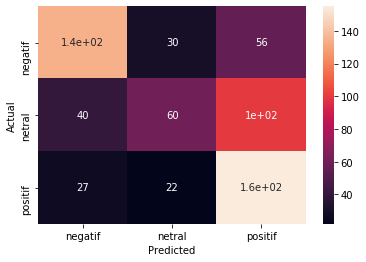

In [21]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [22]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# Create parameter grid
# {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# parameters = {"learning_rate": [0.001, 0.01, 0.1, 0.4],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10, 12],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0.001, 0.01, 0.025, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])